In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.linalg import inv
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import TensorDataset
from torch.cuda.amp import autocast

from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from PIL import Image

from transformers import ViTModel, ViTImageProcessor

import timm
from timm import create_model

from torch_geometric.nn import LabelPropagation
from torch_geometric.utils import dense_to_sparse

import numpy as np
import pandas as pd

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

import os
import requests
import zipfile
from tqdm import tqdm
from collections import defaultdict, Counter
import random
import matplotlib.pyplot as plt
from torch.linalg import inv
import seaborn as sns
import medmnist

In [4]:
torch.cuda.empty_cache()

In [22]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [36]:
img_size=224

batch_size = 32

epochs = 30

num_epochs = 30

learning_rate = 0.001

num_classes = 7

seed=42

In [6]:
class NumpyDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = (image * 255).astype(np.uint8)
        label = int(label) # int label 1d

        # CHW
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

def compute_class_counts(labels_path):
    labels = np.load(labels_path).flatten()  
    return dict(Counter(labels))  

def load_datasets(img_size=img_size, batch_size=batch_size):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [7]:
path = '/home/dime/Desktop/Pre-thesis/data/dermamnist_224'

In [8]:
model_name = 'vit_large_patch16_224'
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
state_dict = torch.load('/home/dime/Desktop/Pre-thesis/vit_best_model.pth')
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('vit.', '')
    new_state_dict[new_key] = v
model.load_state_dict(new_state_dict, strict=False)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

feature_extractor = feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))
feature_extractor = feature_extractor.to(device)
#torch.save(feature_extractor.state_dict(), "vit_best_model_feature_extractor.pth")
model.reset_classifier(0)

images = np.load('/home/dime/Desktop/Pre-thesis/data/dermamnist_224/train_images.npy')

images_tensor = torch.stack([transform(torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)) for image in images])
images_tensor = images_tensor.to(device)

/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
torch.cuda.empty_cache()

In [9]:
images_tensor.shape

torch.Size([7007, 3, 224, 224])

In [10]:
dataset = TensorDataset(images_tensor) 
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size)

feature_list = []
with torch.no_grad():
    for batch in dataloader:
        batch_images = batch[0].to(device)
        with autocast():
            batch_features = feature_extractor(batch_images)[:, 0, :]
            #batch_features = feature_extractor(batch_images)
        feature_list.append(batch_features.cpu())

features = torch.cat(feature_list)

In [11]:
# THIS CRASHES ALL THE TIME

#with torch.no_grad():
#    features = feature_extractor(images_tensor) # (num_images, hidden_size)


#with torch.no_grad():
#    batch_features = feature_extractor(batch_images).detach()

#features_norm = features / features.norm(dim=1)[:, None]
#similarity_matrix = torch.mm(features_norm, features_norm.t())
#threshold = 0.7  # similarity threshold
#adjacency_matrix = (similarity_matrix > threshold).float()
#edge_index, _ = dense_to_sparse(adjacency_matrix)
#
#labels = torch.tensor(np.load('/home/dime/Desktop/Pre-thesis/data/dermamnist_224/train_labels.npy'), dtype=torch.long)
#
#label_prop = LabelPropagation(num_layers=3, alpha=0.1)
#propagated_labels = label_prop(features, edge_index, labels)
#predicted_labels = propagated_labels.argmax(dim=1)

# Embedding Propagation in Image Classification

In the image classification domain, embedding propagation takes a set of feature vectors 
$ z_i \in \mathbb{R}^m $, $ i \in 1, \ldots, |Z| $, obtained from applying a feature extractor to the input images. 

Then, it outputs a set of embeddings $ \tilde{z}_i \in \mathbb{R}^m $ through the following two steps:

### 1: Distance and Adjacency Matrix

For each pair of features $((i, j)$, the model computes:

$
d_{ij}^2 = \| z_i - z_j \|_2^2
$

The adjacency matrix is defined as:

$
A_{ij} = \exp\left(-\frac{d_{ij}^2}{\sigma^2}\right), \quad A_{ii} = 0, \, \forall i
$

where $ \sigma^2 $ is a scaling factor. The authors of TPN (Liu et al., 2019b) chose:

$
\sigma^2 = \text{Var}(d_{ij}^2)
$

to stabilize training.

### 2: Laplacian and Propagator Matrix

The Laplacian of the adjacency matrix is computed as:

$
L = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}, \quad D_{ii} = \sum_j A_{ij}
$

The propagator matrix \\( P \\) is obtained using the label propagation formula described in Zhou et al. (2004):

$
P = (I - \alpha L)^{-1}
$

where $ \alpha \in \mathbb{R} $ is a scaling factor, and $ I $ is the identity matrix.

### 3: Final Embeddings

The embeddings are obtained as:

$
\tilde{z}_i = \sum_j P_{ij} z_j
$

This process enables the propagation of embeddings through the graph structure derived from the feature vectors.


In [ ]:
sigma_factor=1.0
alpha=0.5

distances = torch.cdist(features, features, p=2)
sigma_squared = distances.var().item() * sigma_factor

adjacency_matrix = torch.exp(-distances / sigma_squared)
adjacency_matrix.fill_diagonal_(0)

degree_matrix = torch.diag(adjacency_matrix.sum(dim=1))
D_inv_sqrt = torch.diag(1.0 / torch.sqrt(degree_matrix.diag()))

laplacian = D_inv_sqrt @ adjacency_matrix @ D_inv_sqrt
identity_matrix = torch.eye(laplacian.size(0), device=features.device)

propagator = inv(identity_matrix - alpha * laplacian)

propagated_embeddings = propagator @ features

In [15]:
propagated_embeddings.shape

torch.Size([7007, 1024])

/tmp/ipykernel_21396/3753240680.py:10: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1200x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(nodes, label="Node Feature Value")


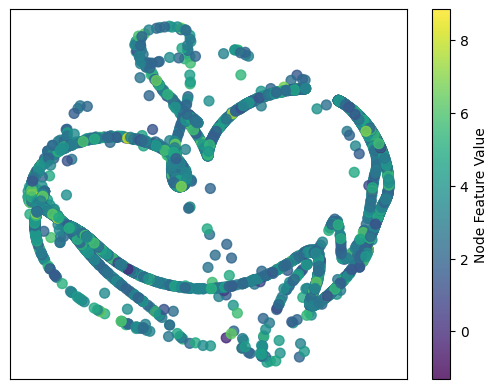

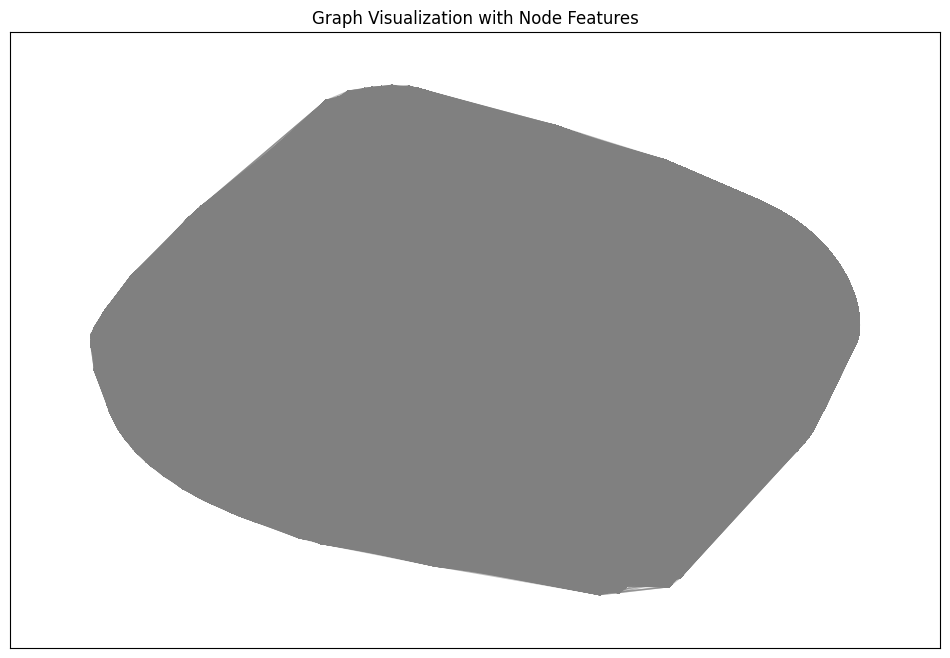

In [28]:
node_colors = propagated_embeddings[:, 0].cpu().numpy()
pos = nx.spring_layout(graph)
nodes = nx.draw_networkx_nodes(graph, pos, node_size=50, alpha=0.8, 
                                node_color=node_colors, cmap=plt.cm.viridis)


plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(graph, pos, alpha=0.5, edge_color="gray")
plt.title("Graph Visualization with Node Features")
plt.colorbar(nodes, label="Node Feature Value")
plt.show()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

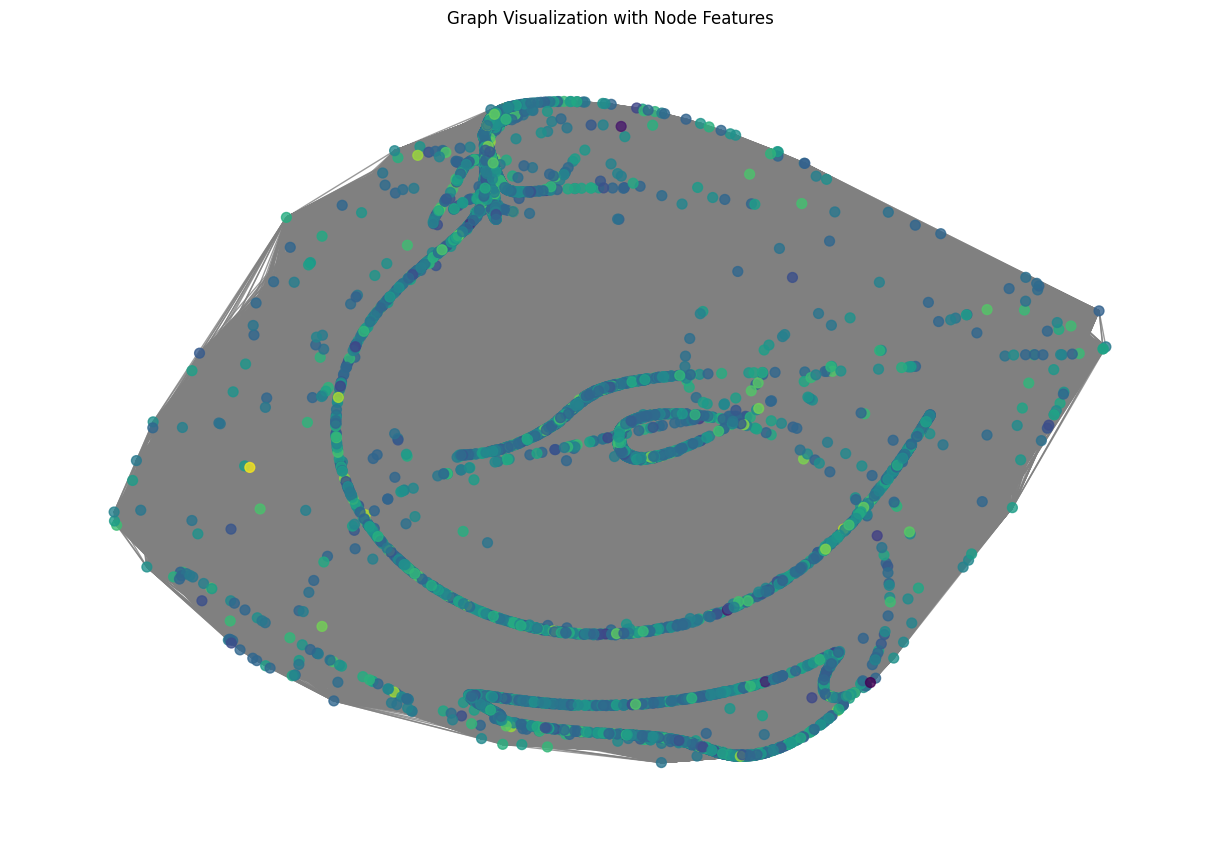

In [27]:
import networkx as nx

edge_index, _ = dense_to_sparse(adjacency_matrix)
graph = nx.Graph()
edges = edge_index.t().cpu().numpy()
graph.add_edges_from(edges)

node_colors = propagated_embeddings[:, 0].cpu().numpy()

plt.figure(figsize=(12, 8))
nx.draw(graph, with_labels=False, node_size=50, alpha=0.8, node_color=node_colors, cmap=plt.cm.viridis, edge_color="gray")
plt.title("Graph Visualization with Node Features")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), label="Node Feature Value")
plt.show()

# EP again

In [29]:
#images = np.load('/home/dime/Desktop/Pre-thesis/data/dermamnist_224/train_images.npy')
#labels = np.load('/home/dime/Desktop/Pre-thesis/data/dermamnist_224/train_labels.npy')
#labels = labels.flatten()  # shape (N,)
#
#propagated_embeddings = torch.load('/home/dime/Desktop/Pre-thesis/propagated_embeddings.pth')
#propagated_embeddings.shape
#
#alpha = 0.5
#sigma_factor = 1.0

embeddings_path = torch.load('/home/dime/Desktop/Pre-thesis/propagated_embeddings.pth')

In [56]:
def embedding_propagation(features: torch.Tensor,
                          alpha: float = 0.5,
                          sigma_factor: float = 1.0) -> torch.Tensor:
    """
    Given a feature matrix (N x m)
    Args:
        features (torch.Tensor): shape (N, m) where N is #samples, m is #dims
        alpha (float): scaling factor in (I - alpha L)^(-1)
        sigma_factor (float): a factor multiplied by distance variance

    Returns:
        torch.Tensor: The propagated embeddings (N, m).
    """

    device = features.device
    # 1) Pairwise distances
    distances = torch.cdist(features, features, p=2)  # (N, N)
    sigma_squared = distances.var().item() * sigma_factor

    # 2) Adjacency
    adjacency_matrix = torch.exp(-distances / sigma_squared)  # (N, N)
    adjacency_matrix.fill_diagonal_(0)

    # 3) Laplacian
    degree_matrix = torch.diag(adjacency_matrix.sum(dim=1))
    D_inv_sqrt = torch.diag(1.0 / torch.sqrt(degree_matrix.diag()))
    laplacian = D_inv_sqrt @ adjacency_matrix @ D_inv_sqrt

    # 4) Propagator
    N = laplacian.size(0)
    identity_matrix = torch.eye(N, device=device)
    # (I - alpha * L)^-1
    propagator = inv(identity_matrix - alpha * laplacian)

    # 5) Propagated embeddings
    propagated_embeddings = propagator @ features
    return propagated_embeddings



class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = create_model('vit_large_patch16_224', pretrained=True, num_classes=num_classes)

        self.vit.head = nn.Sequential(
            nn.Dropout(0.1),
            self.vit.head
        )

    def forward(self, x):
        return self.vit(x)

def freeze_all_but_head(model):
    for param in model.vit.parameters():
        param.requires_grad = False
    
    for param in model.vit.head.parameters():
        param.requires_grad = True

In [54]:
def ep_subset_dataset_percentage(
    dataset,
    embeddings_path,
    percentage=percentage,
    seed=42
):
    random.seed(seed)
    np.random.seed(seed)

    embeddings = torch.load(embeddings_path)  # shape [N, feature_dim]
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()

    N = embeddings.shape[0]
    n_clusters = max(1, int(N * (percentage / 100.0)))

    print(f"EP subset => Using KMeans with n_clusters={n_clusters}, i.e. ~{percentage}% of data.")
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(embeddings)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_


    selected_indices = []
    for cluster_id in range(n_clusters):
        cluster_pts_idx = np.where(labels == cluster_id)[0]
        cluster_pts = embeddings[cluster_pts_idx]
        centroid = centroids[cluster_id]
        dists = np.linalg.norm(cluster_pts - centroid, axis=1)
        best_idx = np.argmin(dists)
        selected_indices.append(cluster_pts_idx[best_idx])

    selected_indices = np.array(selected_indices)
    print(f"Selected {len(selected_indices)} representatives out of {N} total.")


    return Subset(dataset, selected_indices)

def load_data_subset(
    embeddings_path, 
    percentage, 
    batch_size=batch_size, 
    img_size=img_size
):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)


    train_subset = ep_subset_dataset_percentage(
        dataset=train_dataset,
        embeddings_path=embeddings_path,
        percentage=percentage, 
        seed=42
    )

    val_subset = val_dataset
    test_subset = test_dataset

    train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader_subset   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)
    test_loader_subset  = DataLoader(test_subset,  batch_size=batch_size, shuffle=False)

    return train_loader_subset, val_loader_subset, test_loader_subset


In [58]:
def plot_metrics(metrics_log):
    epochs = range(1, len(metrics_log["train_loss"]) + 1)

    # Plot loss
    plt.figure()
    plt.plot(epochs, metrics_log["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics_log["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, metrics_log["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, metrics_log["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.show()

    # Plot F1 score
    plt.figure()
    plt.plot(epochs, metrics_log["train_f1"], label="Train F1 Score")
    plt.plot(epochs, metrics_log["val_f1"], label="Validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Epochs")
    plt.legend()
    plt.show()

def train_subset_model(
    model,
    train_loader_subset,
    val_loader_subset,
    device,
    num_epochs=30,
    lr=0.001,
    patience=5,
    accumulation_steps=4
):
    for param in model.vit.parameters():
        param.requires_grad = False

    for param in model.vit.head.parameters():
        param.requires_grad = True

    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for step, (images, labels) in enumerate(tqdm(train_loader_subset, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader_subset)

        model.eval()
        val_loss_total = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader_subset, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss_total += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss_avg = val_loss_total / len(val_loader_subset)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss_avg)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss_avg:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            torch.save(model.state_dict(), "vit_best_model_10%.pth")
            print("Validation loss improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping")
            break

    # Optionally, plot or print final
    print(f"Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"Final Val F1: {metrics_log['val_f1'][-1]:.4f}")

    plot_metrics(metrics_log)
    return metrics_log

In [57]:
def train_subset_model_multiple_runs(
    device,
    num_runs=3,
    percentage=percentage,
    num_epochs=30,
    lr=0.001,
    patience=5,
    accumulation_steps=4,
    seed=42,
    embeddings_path="/home/dime/Desktop/Pre-thesis/propagated_embeddings.pth"
):
    #set_seed(seed)

    train_loader_subset, val_loader_subset, test_loader_subset = load_data_subset(
        batch_size=batch_size,
        img_size=img_size,
        percentage=percentage,         
        embeddings_path=embeddings_path,  
    )

    val_accuracies = []
    val_f1s = []
    val_losses = []

    for run_idx in range(num_runs):
        print(f"\n===== RUN {run_idx + 1}/{num_runs} (Percentage={percentage}%) =====")

        set_seed(seed + run_idx)  
        model = ViTModel(num_classes=num_classes)

        metrics_log = train_subset_model(
            model=model,
            train_loader_subset=train_loader_subset,
            val_loader_subset=val_loader_subset,
            device=device,
            num_epochs=num_epochs,
            lr=lr,
            patience=patience,
            accumulation_steps=accumulation_steps
        )

        final_val_accuracy = metrics_log["val_accuracy"][-1]
        final_val_f1 = metrics_log["val_f1"][-1]
        final_val_loss = metrics_log["val_loss"][-1]

        val_accuracies.append(final_val_accuracy)
        val_f1s.append(final_val_f1)
        val_losses.append(final_val_loss)

        print(f"Run {run_idx+1} => ValAcc: {final_val_accuracy:.4f}, ValF1: {final_val_f1:.4f}, ValLoss: {final_val_loss:.4f}")

    val_loss_mean = np.mean(val_losses)
    val_loss_std = np.std(val_losses)
    val_acc_mean = np.mean(val_accuracies)
    val_acc_std = np.std(val_accuracies)
    val_f1_mean = np.mean(val_f1s)
    val_f1_std = np.std(val_f1s)

    print("\n===== SUMMARY OVER MULTIPLE RUNS =====")
    print(f"Validation Loss: {val_loss_mean:.4f} ± {val_loss_std:.4f}")
    print(f"Validation Accuracy: {val_acc_mean:.4f} ± {val_acc_std:.4f}")
    print(f"Validation F1: {val_f1_mean:.4f} ± {val_f1_std:.4f}")

    return {
        "val_loss_mean": val_loss_mean,
        "val_loss_std": val_loss_std,
        "val_acc_mean": val_acc_mean,
        "val_acc_std": val_acc_std,
        "val_f1_mean": val_f1_mean,
        "val_f1_std": val_f1_std
    }


# 0.1 % of the data

EP subset => Using KMeans with n_clusters=7, i.e. ~0.1% of data.
Selected 7 representatives out of 7007 total.

===== RUN 1/3 (Percentage=0.1%) =====


Training Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [1/30]:
  Train Loss: 1.9987, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.3534, Accuracy: 0.0997, F1: 0.1324
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [2/30]:
  Train Loss: 2.1912, Accuracy: 0.2857, F1: 0.3095
  Val Loss: 2.3808, Accuracy: 0.0867, F1: 0.1215
No improvement in validation loss for 1 epoch(s).


Training Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [3/30]:
  Train Loss: 1.8364, Accuracy: 0.1429, F1: 0.0714
  Val Loss: 2.3509, Accuracy: 0.0927, F1: 0.1231
Validation loss improved. Model saved.


Training Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [4/30]:
  Train Loss: 1.7691, Accuracy: 0.5714, F1: 0.4952
  Val Loss: 2.3574, Accuracy: 0.0857, F1: 0.1155
No improvement in validation loss for 1 epoch(s).


Training Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [5/30]:
  Train Loss: 1.7790, Accuracy: 0.2857, F1: 0.2959
  Val Loss: 2.3400, Accuracy: 0.1067, F1: 0.1435
Validation loss improved. Model saved.


Training Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [6/30]:
  Train Loss: 1.8121, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.3222, Accuracy: 0.0987, F1: 0.1352
Validation loss improved. Model saved.


Training Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [7/30]:
  Train Loss: 2.5447, Accuracy: 0.2857, F1: 0.3571
  Val Loss: 2.3535, Accuracy: 0.0828, F1: 0.1018
No improvement in validation loss for 1 epoch(s).


Training Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [8/30]:
  Train Loss: 2.8057, Accuracy: 0.1429, F1: 0.0952
  Val Loss: 2.3240, Accuracy: 0.0897, F1: 0.1163
No improvement in validation loss for 2 epoch(s).


Training Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [9/30]:
  Train Loss: 2.1041, Accuracy: 0.2857, F1: 0.2857
  Val Loss: 2.3047, Accuracy: 0.0937, F1: 0.1237
Validation loss improved. Model saved.


Training Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [10/30]:
  Train Loss: 1.8573, Accuracy: 0.2857, F1: 0.2959
  Val Loss: 2.2933, Accuracy: 0.0987, F1: 0.1307
Validation loss improved. Model saved.


Training Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [11/30]:
  Train Loss: 1.9314, Accuracy: 0.4286, F1: 0.4095
  Val Loss: 2.3634, Accuracy: 0.0847, F1: 0.1078
No improvement in validation loss for 1 epoch(s).


Training Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [12/30]:
  Train Loss: 2.1443, Accuracy: 0.1429, F1: 0.0952
  Val Loss: 2.3788, Accuracy: 0.0678, F1: 0.0856
No improvement in validation loss for 2 epoch(s).


Training Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [13/30]:
  Train Loss: 2.3598, Accuracy: 0.1429, F1: 0.0952
  Val Loss: 2.3334, Accuracy: 0.0798, F1: 0.1065
No improvement in validation loss for 3 epoch(s).


Training Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [14/30]:
  Train Loss: 2.9279, Accuracy: 0.1429, F1: 0.0952
  Val Loss: 2.2970, Accuracy: 0.0957, F1: 0.1325
No improvement in validation loss for 4 epoch(s).


Training Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [15/30]:
  Train Loss: 2.2600, Accuracy: 0.4286, F1: 0.4048
  Val Loss: 2.3888, Accuracy: 0.0788, F1: 0.1019
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 2.2600
Final Train Accuracy: 0.4286
Final Train F1: 0.4048
Final Val Loss: 2.3888
Final Val Accuracy: 0.0788
Final Val F1: 0.1019


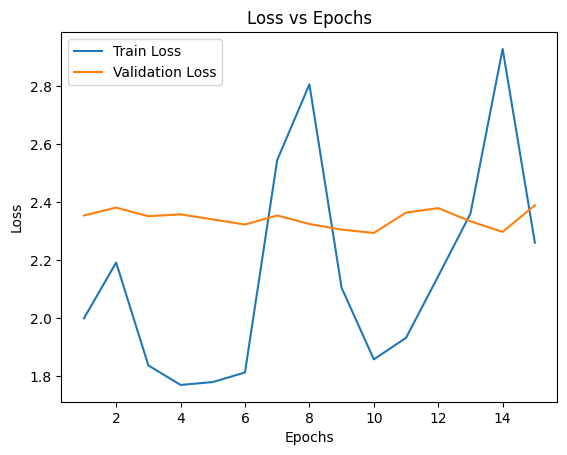

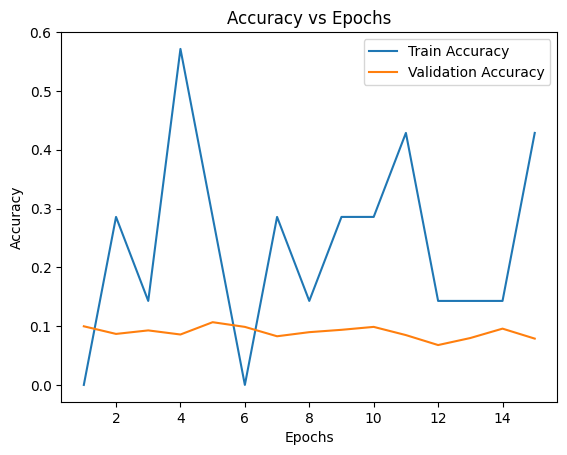

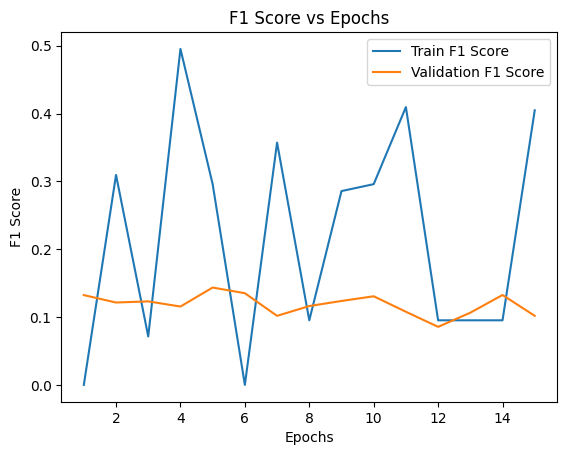

Run 1 => ValAcc: 0.0788, ValF1: 0.1019, ValLoss: 2.3888

===== RUN 2/3 (Percentage=0.1%) =====


Training Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [1/30]:
  Train Loss: 2.8484, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.0255, Accuracy: 0.1705, F1: 0.2218
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [2/30]:
  Train Loss: 2.3901, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.0878, Accuracy: 0.1765, F1: 0.2320
No improvement in validation loss for 1 epoch(s).


Training Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [3/30]:
  Train Loss: 2.9290, Accuracy: 0.2857, F1: 0.2857
  Val Loss: 2.0862, Accuracy: 0.1705, F1: 0.2172
No improvement in validation loss for 2 epoch(s).


Training Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [4/30]:
  Train Loss: 3.1363, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.0947, Accuracy: 0.1665, F1: 0.2157
No improvement in validation loss for 3 epoch(s).


Training Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [5/30]:
  Train Loss: 2.3232, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.0429, Accuracy: 0.1765, F1: 0.2230
No improvement in validation loss for 4 epoch(s).


Training Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [6/30]:
  Train Loss: 2.3668, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.0366, Accuracy: 0.1864, F1: 0.2452
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 2.3668
Final Train Accuracy: 0.0000
Final Train F1: 0.0000
Final Val Loss: 2.0366
Final Val Accuracy: 0.1864
Final Val F1: 0.2452


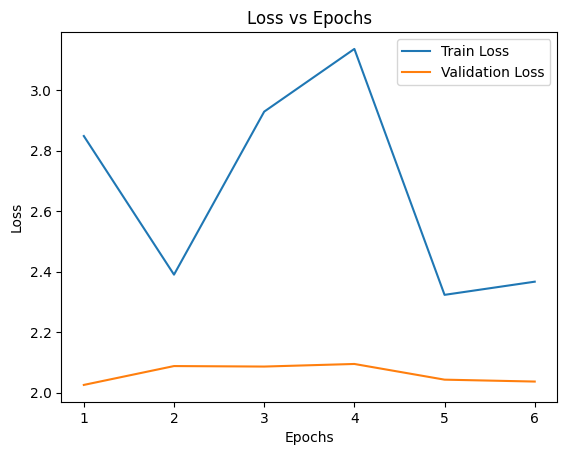

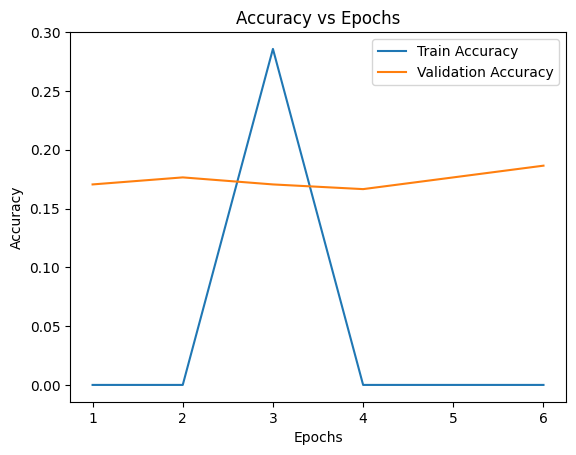

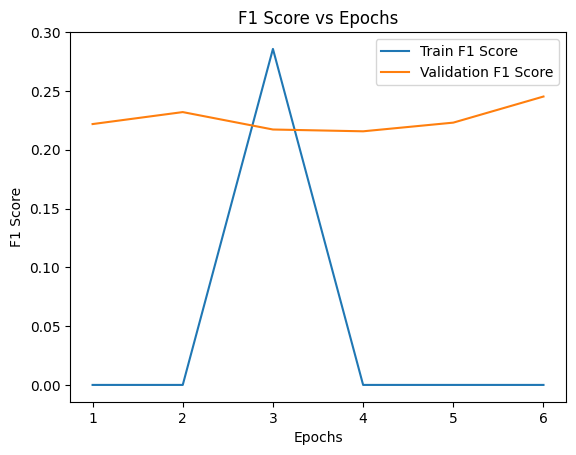

Run 2 => ValAcc: 0.1864, ValF1: 0.2452, ValLoss: 2.0366

===== RUN 3/3 (Percentage=0.1%) =====


Training Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [1/30]:
  Train Loss: 4.3809, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.7907, Accuracy: 0.1186, F1: 0.0436
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [2/30]:
  Train Loss: 3.7726, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.8853, Accuracy: 0.1236, F1: 0.0498
No improvement in validation loss for 1 epoch(s).


Training Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [3/30]:
  Train Loss: 3.6575, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.8205, Accuracy: 0.1107, F1: 0.0348
No improvement in validation loss for 2 epoch(s).


Training Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [4/30]:
  Train Loss: 4.1197, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.8139, Accuracy: 0.1147, F1: 0.0336
No improvement in validation loss for 3 epoch(s).


Training Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [5/30]:
  Train Loss: 3.5642, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.8225, Accuracy: 0.1176, F1: 0.0499
No improvement in validation loss for 4 epoch(s).


Training Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [6/30]:
  Train Loss: 3.7593, Accuracy: 0.0000, F1: 0.0000
  Val Loss: 2.8068, Accuracy: 0.1147, F1: 0.0392
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 3.7593
Final Train Accuracy: 0.0000
Final Train F1: 0.0000
Final Val Loss: 2.8068
Final Val Accuracy: 0.1147
Final Val F1: 0.0392


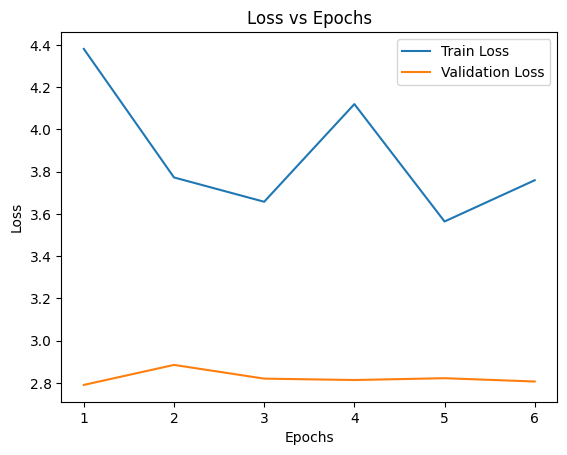

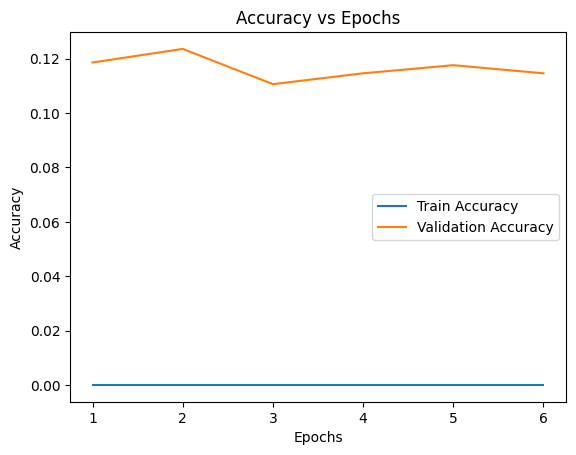

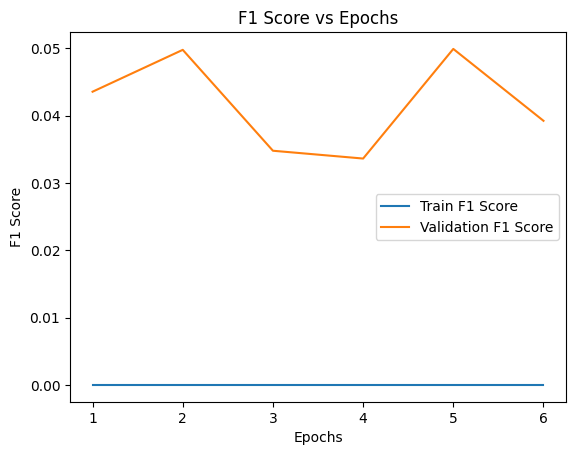

Run 3 => ValAcc: 0.1147, ValF1: 0.0392, ValLoss: 2.8068

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 2.4107 ± 0.3148
Validation Accuracy: 0.1266 ± 0.0448
Validation F1: 0.1288 ± 0.0862

 Final Val Accuracy = 0.1266 ± 0.0448


In [60]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    percentage = 0.1
    embeddings_file = "/home/dime/Desktop/Pre-thesis/propagated_embeddings.pth"

    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=percentage,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42,
        embeddings_path=embeddings_file
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")


# 1% of the data

# 1% of the data

EP subset => Using KMeans with n_clusters=70, i.e. ~1% of data.
Selected 70 representatives out of 7007 total.

===== RUN 1/3 (Percentage=1%) =====


Training Epoch 1/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [1/30]:
  Train Loss: 2.3419, Accuracy: 0.0714, F1: 0.0358
  Val Loss: 2.3317, Accuracy: 0.1087, F1: 0.1410
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [2/30]:
  Train Loss: 2.1505, Accuracy: 0.1571, F1: 0.1497
  Val Loss: 2.3542, Accuracy: 0.0997, F1: 0.1349
No improvement in validation loss for 1 epoch(s).


Training Epoch 3/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [3/30]:
  Train Loss: 2.2553, Accuracy: 0.0857, F1: 0.0595
  Val Loss: 2.3454, Accuracy: 0.0887, F1: 0.1113
No improvement in validation loss for 2 epoch(s).


Training Epoch 4/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [4/30]:
  Train Loss: 2.6247, Accuracy: 0.1429, F1: 0.1663
  Val Loss: 2.3337, Accuracy: 0.0957, F1: 0.1313
No improvement in validation loss for 3 epoch(s).


Training Epoch 5/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [5/30]:
  Train Loss: 2.3601, Accuracy: 0.0571, F1: 0.0561
  Val Loss: 2.3671, Accuracy: 0.0907, F1: 0.1165
No improvement in validation loss for 4 epoch(s).


Training Epoch 6/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [6/30]:
  Train Loss: 2.4590, Accuracy: 0.1429, F1: 0.1195
  Val Loss: 2.3396, Accuracy: 0.0808, F1: 0.1132
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 2.4590
Final Train Accuracy: 0.1429
Final Train F1: 0.1195
Final Val Loss: 2.3396
Final Val Accuracy: 0.0808
Final Val F1: 0.1132


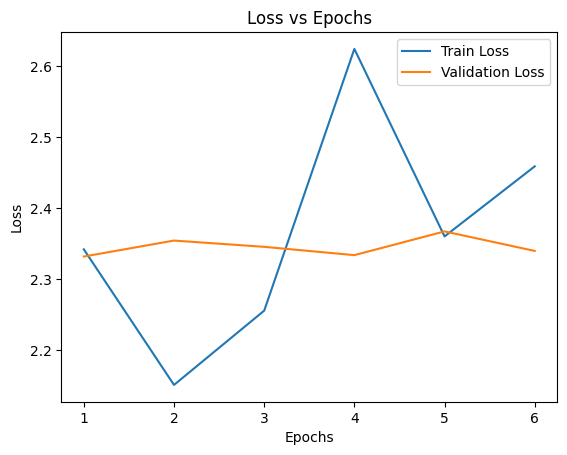

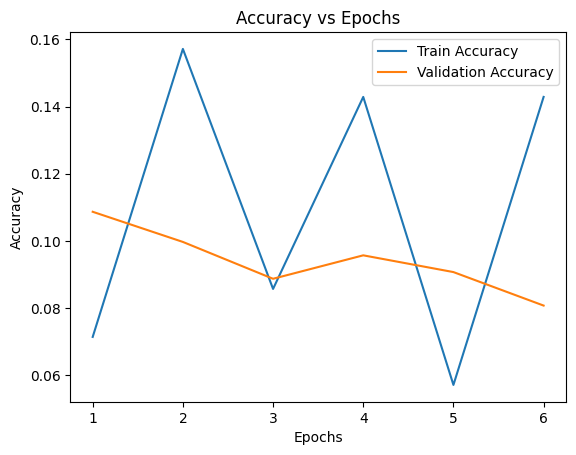

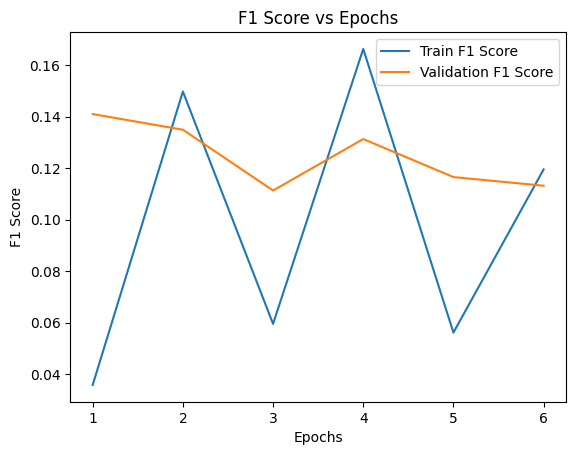

Run 1 => ValAcc: 0.0808, ValF1: 0.1132, ValLoss: 2.3396

===== RUN 2/3 (Percentage=1%) =====


Training Epoch 1/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [1/30]:
  Train Loss: 2.4605, Accuracy: 0.1143, F1: 0.1629
  Val Loss: 2.0610, Accuracy: 0.1575, F1: 0.2123
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [2/30]:
  Train Loss: 2.2142, Accuracy: 0.2000, F1: 0.2369
  Val Loss: 2.1059, Accuracy: 0.1615, F1: 0.2136
No improvement in validation loss for 1 epoch(s).


Training Epoch 3/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [3/30]:
  Train Loss: 2.1696, Accuracy: 0.2286, F1: 0.2749
  Val Loss: 1.9541, Accuracy: 0.2064, F1: 0.2563
Validation loss improved. Model saved.


Training Epoch 4/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [4/30]:
  Train Loss: 1.9591, Accuracy: 0.1857, F1: 0.2371
  Val Loss: 2.0506, Accuracy: 0.1665, F1: 0.2058
No improvement in validation loss for 1 epoch(s).


Training Epoch 5/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [5/30]:
  Train Loss: 2.2619, Accuracy: 0.2143, F1: 0.2768
  Val Loss: 2.0173, Accuracy: 0.1715, F1: 0.2159
No improvement in validation loss for 2 epoch(s).


Training Epoch 6/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [6/30]:
  Train Loss: 2.2471, Accuracy: 0.2714, F1: 0.3436
  Val Loss: 2.0825, Accuracy: 0.1725, F1: 0.2288
No improvement in validation loss for 3 epoch(s).


Training Epoch 7/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [7/30]:
  Train Loss: 2.3654, Accuracy: 0.2143, F1: 0.2495
  Val Loss: 2.0229, Accuracy: 0.1815, F1: 0.2357
No improvement in validation loss for 4 epoch(s).


Training Epoch 8/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [8/30]:
  Train Loss: 2.0878, Accuracy: 0.1571, F1: 0.1900
  Val Loss: 2.0941, Accuracy: 0.1765, F1: 0.2243
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 2.0878
Final Train Accuracy: 0.1571
Final Train F1: 0.1900
Final Val Loss: 2.0941
Final Val Accuracy: 0.1765
Final Val F1: 0.2243


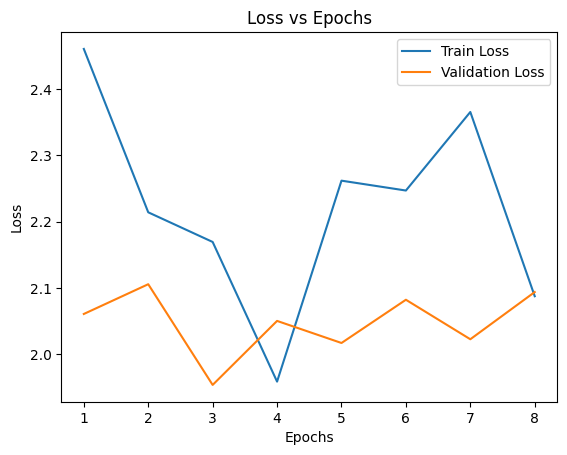

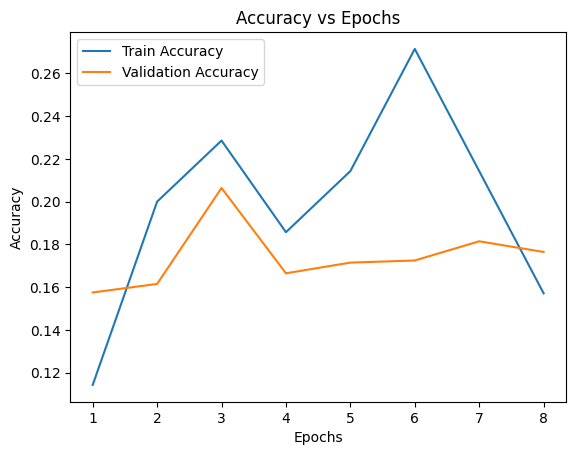

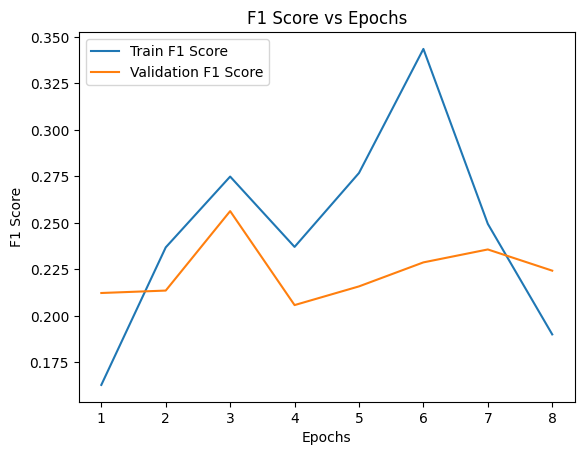

Run 2 => ValAcc: 0.1765, ValF1: 0.2243, ValLoss: 2.0941

===== RUN 3/3 (Percentage=1%) =====


Training Epoch 1/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [1/30]:
  Train Loss: 2.9747, Accuracy: 0.0857, F1: 0.0183
  Val Loss: 2.8313, Accuracy: 0.1206, F1: 0.0456
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [2/30]:
  Train Loss: 3.2414, Accuracy: 0.1286, F1: 0.0713
  Val Loss: 2.9053, Accuracy: 0.1097, F1: 0.0292
No improvement in validation loss for 1 epoch(s).


Training Epoch 3/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [3/30]:
  Train Loss: 2.8252, Accuracy: 0.1000, F1: 0.0208
  Val Loss: 2.8034, Accuracy: 0.1137, F1: 0.0337
Validation loss improved. Model saved.


Training Epoch 4/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [4/30]:
  Train Loss: 2.7587, Accuracy: 0.1143, F1: 0.0244
  Val Loss: 2.7616, Accuracy: 0.1196, F1: 0.0454
Validation loss improved. Model saved.


Training Epoch 5/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [5/30]:
  Train Loss: 3.4983, Accuracy: 0.1571, F1: 0.1054
  Val Loss: 2.8301, Accuracy: 0.1147, F1: 0.0392
No improvement in validation loss for 1 epoch(s).


Training Epoch 6/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [6/30]:
  Train Loss: 2.7486, Accuracy: 0.1143, F1: 0.0892
  Val Loss: 2.7990, Accuracy: 0.1087, F1: 0.0276
No improvement in validation loss for 2 epoch(s).


Training Epoch 7/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [7/30]:
  Train Loss: 3.0932, Accuracy: 0.1000, F1: 0.0211
  Val Loss: 2.7605, Accuracy: 0.1176, F1: 0.0449
Validation loss improved. Model saved.


Training Epoch 8/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [8/30]:
  Train Loss: 3.0193, Accuracy: 0.1286, F1: 0.0734
  Val Loss: 2.7493, Accuracy: 0.1176, F1: 0.0431
Validation loss improved. Model saved.


Training Epoch 9/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [9/30]:
  Train Loss: 3.0898, Accuracy: 0.1000, F1: 0.0414
  Val Loss: 2.7892, Accuracy: 0.1186, F1: 0.0450
No improvement in validation loss for 1 epoch(s).


Training Epoch 10/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [10/30]:
  Train Loss: 2.6357, Accuracy: 0.1286, F1: 0.0959
  Val Loss: 2.7903, Accuracy: 0.1147, F1: 0.0392
No improvement in validation loss for 2 epoch(s).


Training Epoch 11/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [11/30]:
  Train Loss: 2.5495, Accuracy: 0.1143, F1: 0.0948
  Val Loss: 2.8185, Accuracy: 0.1196, F1: 0.0431
No improvement in validation loss for 3 epoch(s).


Training Epoch 12/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [12/30]:
  Train Loss: 3.0772, Accuracy: 0.0857, F1: 0.0390
  Val Loss: 2.7851, Accuracy: 0.1176, F1: 0.0400
No improvement in validation loss for 4 epoch(s).


Training Epoch 13/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [13/30]:
  Train Loss: 2.9424, Accuracy: 0.1000, F1: 0.0452
  Val Loss: 2.7574, Accuracy: 0.1196, F1: 0.0437
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 2.9424
Final Train Accuracy: 0.1000
Final Train F1: 0.0452
Final Val Loss: 2.7574
Final Val Accuracy: 0.1196
Final Val F1: 0.0437


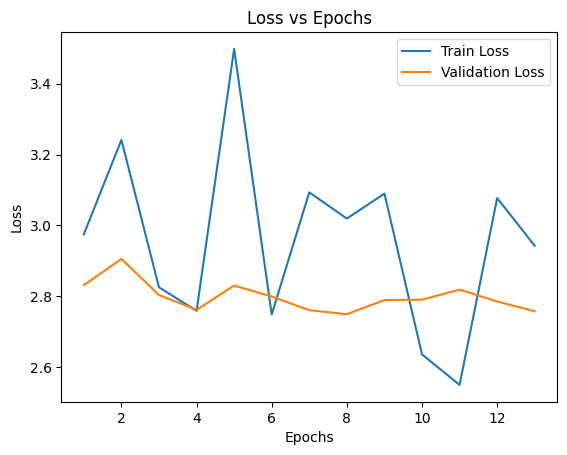

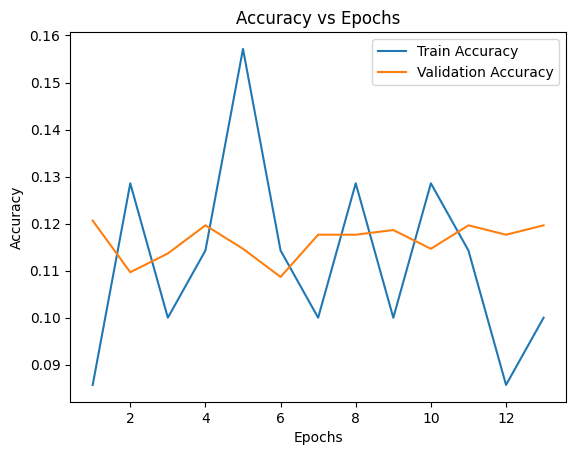

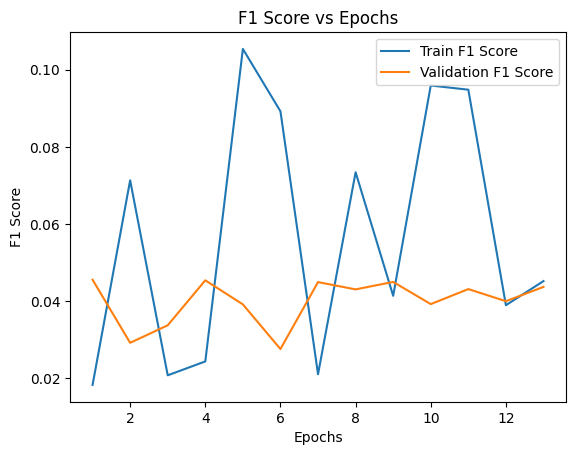

Run 3 => ValAcc: 0.1196, ValF1: 0.0437, ValLoss: 2.7574

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 2.3970 ± 0.2738
Validation Accuracy: 0.1256 ± 0.0393
Validation F1: 0.1271 ± 0.0744

 Final Val Accuracy = 0.1256 ± 0.0393


In [61]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    percentage = 1
    embeddings_file = "/home/dime/Desktop/Pre-thesis/propagated_embeddings.pth"

    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=percentage,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42,
        embeddings_path=embeddings_file
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")

# 10% of the data

EP subset => Using KMeans with n_clusters=700, i.e. ~10% of data.
Selected 700 representatives out of 7007 total.

===== RUN 1/3 (Percentage=10%) =====


Training Epoch 1/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [1/30]:
  Train Loss: 2.0143, Accuracy: 0.3114, F1: 0.3753
  Val Loss: 1.4935, Accuracy: 0.6650, F1: 0.5378
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [2/30]:
  Train Loss: 1.3521, Accuracy: 0.6771, F1: 0.5770
  Val Loss: 1.4344, Accuracy: 0.6510, F1: 0.5356
Validation loss improved. Model saved.


Training Epoch 3/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [3/30]:
  Train Loss: 1.4332, Accuracy: 0.6243, F1: 0.5502
  Val Loss: 1.3797, Accuracy: 0.6660, F1: 0.5370
Validation loss improved. Model saved.


Training Epoch 4/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [4/30]:
  Train Loss: 1.3171, Accuracy: 0.6829, F1: 0.5805
  Val Loss: 1.3148, Accuracy: 0.6530, F1: 0.5365
Validation loss improved. Model saved.


Training Epoch 5/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [5/30]:
  Train Loss: 1.1927, Accuracy: 0.6586, F1: 0.5719
  Val Loss: 1.2334, Accuracy: 0.6570, F1: 0.5343
Validation loss improved. Model saved.


Training Epoch 6/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [6/30]:
  Train Loss: 1.2129, Accuracy: 0.6786, F1: 0.5735
  Val Loss: 1.2566, Accuracy: 0.6590, F1: 0.5325
No improvement in validation loss for 1 epoch(s).


Training Epoch 7/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [7/30]:
  Train Loss: 1.2526, Accuracy: 0.6700, F1: 0.5666
  Val Loss: 1.2292, Accuracy: 0.6620, F1: 0.5384
Validation loss improved. Model saved.


Training Epoch 8/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [8/30]:
  Train Loss: 1.2004, Accuracy: 0.6757, F1: 0.5720
  Val Loss: 1.2106, Accuracy: 0.6630, F1: 0.5357
Validation loss improved. Model saved.


Training Epoch 9/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [9/30]:
  Train Loss: 1.1999, Accuracy: 0.6657, F1: 0.5656
  Val Loss: 1.2540, Accuracy: 0.6640, F1: 0.5366
No improvement in validation loss for 1 epoch(s).


Training Epoch 10/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [10/30]:
  Train Loss: 1.1859, Accuracy: 0.6786, F1: 0.5738
  Val Loss: 1.2375, Accuracy: 0.6710, F1: 0.5428
No improvement in validation loss for 2 epoch(s).


Training Epoch 11/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [11/30]:
  Train Loss: 1.2114, Accuracy: 0.6943, F1: 0.5794
  Val Loss: 1.2566, Accuracy: 0.6650, F1: 0.5385
No improvement in validation loss for 3 epoch(s).


Training Epoch 12/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [12/30]:
  Train Loss: 1.3155, Accuracy: 0.5729, F1: 0.5294
  Val Loss: 1.2429, Accuracy: 0.6311, F1: 0.5340
No improvement in validation loss for 4 epoch(s).


Training Epoch 13/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [13/30]:
  Train Loss: 1.2108, Accuracy: 0.6700, F1: 0.5707
  Val Loss: 1.4161, Accuracy: 0.6690, F1: 0.5384
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 1.2108
Final Train Accuracy: 0.6700
Final Train F1: 0.5707
Final Val Loss: 1.4161
Final Val Accuracy: 0.6690
Final Val F1: 0.5384


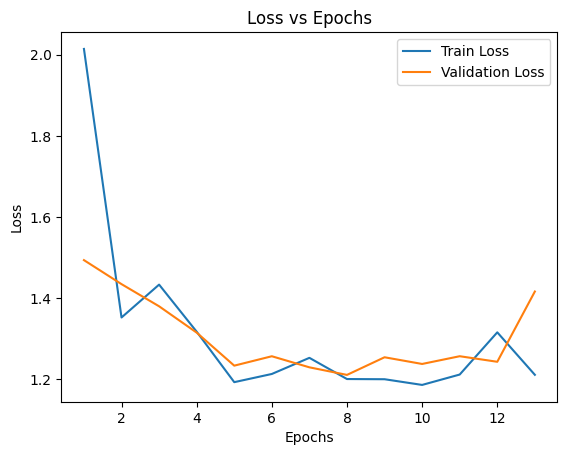

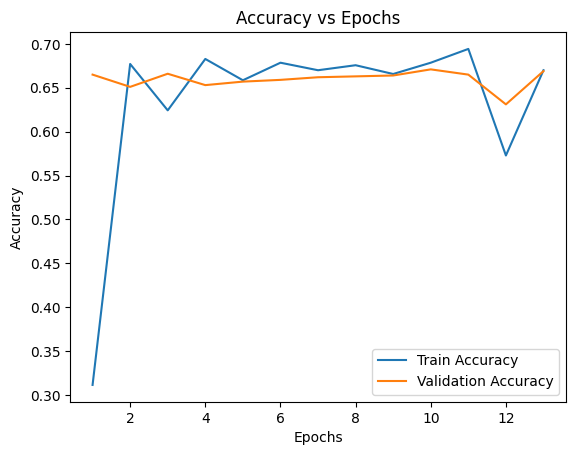

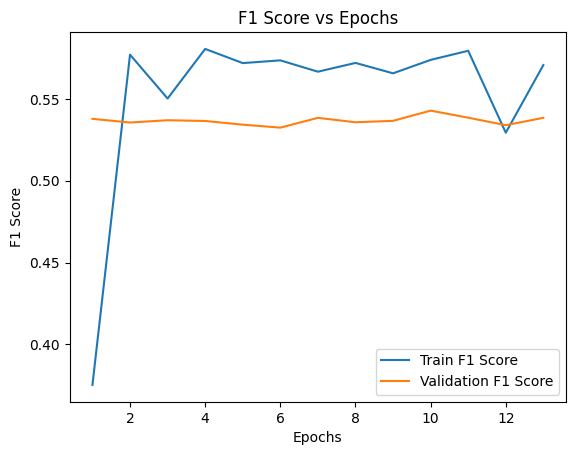

Run 1 => ValAcc: 0.6690, ValF1: 0.5384, ValLoss: 1.4161

===== RUN 2/3 (Percentage=10%) =====


Training Epoch 1/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [1/30]:
  Train Loss: 1.9241, Accuracy: 0.3329, F1: 0.3924
  Val Loss: 1.6260, Accuracy: 0.6461, F1: 0.5323
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [2/30]:
  Train Loss: 1.3778, Accuracy: 0.6314, F1: 0.5634
  Val Loss: 1.3607, Accuracy: 0.5952, F1: 0.5183
Validation loss improved. Model saved.


Training Epoch 3/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [3/30]:
  Train Loss: 1.3134, Accuracy: 0.6557, F1: 0.5712
  Val Loss: 1.3672, Accuracy: 0.6620, F1: 0.5329
No improvement in validation loss for 1 epoch(s).


Training Epoch 4/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [4/30]:
  Train Loss: 1.2671, Accuracy: 0.6843, F1: 0.5727
  Val Loss: 1.3119, Accuracy: 0.6361, F1: 0.5302
Validation loss improved. Model saved.


Training Epoch 5/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [5/30]:
  Train Loss: 1.2776, Accuracy: 0.6329, F1: 0.5609
  Val Loss: 1.3702, Accuracy: 0.6660, F1: 0.5349
No improvement in validation loss for 1 epoch(s).


Training Epoch 6/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [6/30]:
  Train Loss: 1.2648, Accuracy: 0.6943, F1: 0.5730
  Val Loss: 1.4950, Accuracy: 0.6680, F1: 0.5358
No improvement in validation loss for 2 epoch(s).


Training Epoch 7/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [7/30]:
  Train Loss: 1.2666, Accuracy: 0.6643, F1: 0.5667
  Val Loss: 1.2612, Accuracy: 0.6550, F1: 0.5409
Validation loss improved. Model saved.


Training Epoch 8/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [8/30]:
  Train Loss: 1.2077, Accuracy: 0.6443, F1: 0.5668
  Val Loss: 1.2598, Accuracy: 0.6660, F1: 0.5352
Validation loss improved. Model saved.


Training Epoch 9/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [9/30]:
  Train Loss: 1.2220, Accuracy: 0.6843, F1: 0.5701
  Val Loss: 1.2420, Accuracy: 0.6640, F1: 0.5382
Validation loss improved. Model saved.


Training Epoch 10/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [10/30]:
  Train Loss: 1.2023, Accuracy: 0.6600, F1: 0.5660
  Val Loss: 1.2040, Accuracy: 0.6600, F1: 0.5377
Validation loss improved. Model saved.


Training Epoch 11/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [11/30]:
  Train Loss: 1.1855, Accuracy: 0.6757, F1: 0.5884
  Val Loss: 1.2152, Accuracy: 0.6630, F1: 0.5391
No improvement in validation loss for 1 epoch(s).


Training Epoch 12/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [12/30]:
  Train Loss: 1.2219, Accuracy: 0.6829, F1: 0.5804
  Val Loss: 1.2449, Accuracy: 0.6640, F1: 0.5356
No improvement in validation loss for 2 epoch(s).


Training Epoch 13/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [13/30]:
  Train Loss: 1.1719, Accuracy: 0.6943, F1: 0.5809
  Val Loss: 1.2358, Accuracy: 0.6630, F1: 0.5337
No improvement in validation loss for 3 epoch(s).


Training Epoch 14/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [14/30]:
  Train Loss: 1.1908, Accuracy: 0.6800, F1: 0.5848
  Val Loss: 1.2459, Accuracy: 0.6610, F1: 0.5348
No improvement in validation loss for 4 epoch(s).


Training Epoch 15/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [15/30]:
  Train Loss: 1.1877, Accuracy: 0.6871, F1: 0.5739
  Val Loss: 1.2464, Accuracy: 0.6650, F1: 0.5365
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 1.1877
Final Train Accuracy: 0.6871
Final Train F1: 0.5739
Final Val Loss: 1.2464
Final Val Accuracy: 0.6650
Final Val F1: 0.5365


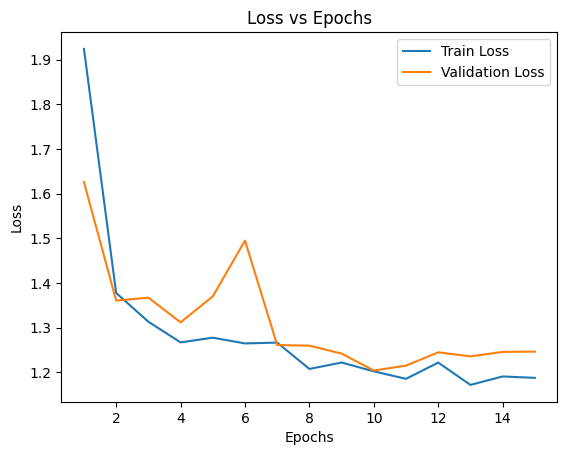

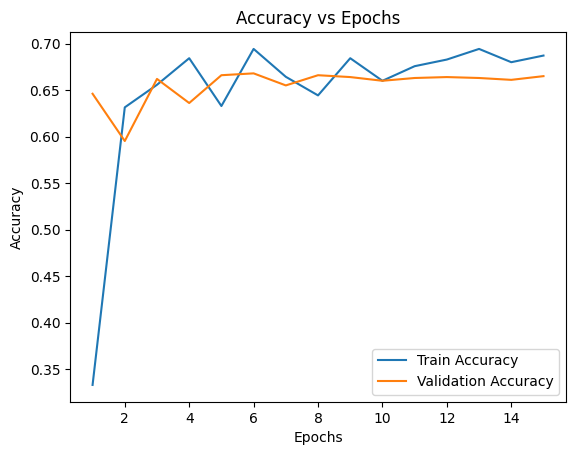

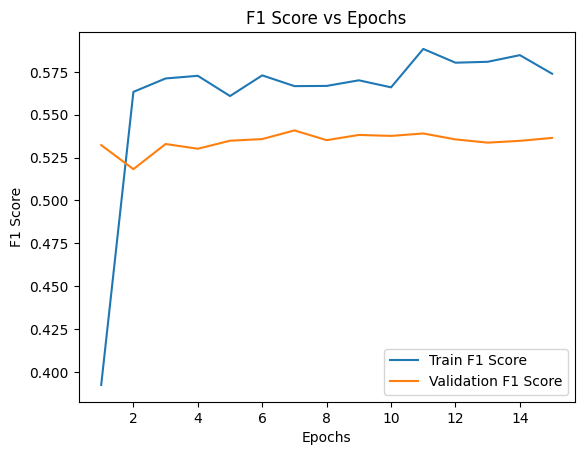

Run 2 => ValAcc: 0.6650, ValF1: 0.5365, ValLoss: 1.2464

===== RUN 3/3 (Percentage=10%) =====


Training Epoch 1/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [1/30]:
  Train Loss: 2.4848, Accuracy: 0.2586, F1: 0.2928
  Val Loss: 1.9189, Accuracy: 0.5115, F1: 0.4786
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [2/30]:
  Train Loss: 1.7252, Accuracy: 0.6586, F1: 0.5686
  Val Loss: 1.8810, Accuracy: 0.6650, F1: 0.5350
Validation loss improved. Model saved.


Training Epoch 3/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [3/30]:
  Train Loss: 1.6526, Accuracy: 0.6100, F1: 0.5454
  Val Loss: 1.5506, Accuracy: 0.6311, F1: 0.5390
Validation loss improved. Model saved.


Training Epoch 4/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [4/30]:
  Train Loss: 1.4379, Accuracy: 0.6500, F1: 0.5651
  Val Loss: 1.4428, Accuracy: 0.6640, F1: 0.5356
Validation loss improved. Model saved.


Training Epoch 5/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [5/30]:
  Train Loss: 1.2928, Accuracy: 0.6786, F1: 0.5708
  Val Loss: 1.3028, Accuracy: 0.6580, F1: 0.5432
Validation loss improved. Model saved.


Training Epoch 6/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [6/30]:
  Train Loss: 1.2316, Accuracy: 0.6257, F1: 0.5529
  Val Loss: 1.2353, Accuracy: 0.6620, F1: 0.5339
Validation loss improved. Model saved.


Training Epoch 7/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [7/30]:
  Train Loss: 1.1548, Accuracy: 0.6800, F1: 0.5801
  Val Loss: 1.2278, Accuracy: 0.6600, F1: 0.5320
Validation loss improved. Model saved.


Training Epoch 8/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [8/30]:
  Train Loss: 1.1685, Accuracy: 0.6900, F1: 0.5777
  Val Loss: 1.2012, Accuracy: 0.6610, F1: 0.5351
Validation loss improved. Model saved.


Training Epoch 9/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [9/30]:
  Train Loss: 1.2073, Accuracy: 0.6629, F1: 0.5710
  Val Loss: 1.2685, Accuracy: 0.6650, F1: 0.5397
No improvement in validation loss for 1 epoch(s).


Training Epoch 10/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [10/30]:
  Train Loss: 1.1597, Accuracy: 0.6743, F1: 0.5695
  Val Loss: 1.2267, Accuracy: 0.6650, F1: 0.5367
No improvement in validation loss for 2 epoch(s).


Training Epoch 11/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [11/30]:
  Train Loss: 1.1916, Accuracy: 0.6886, F1: 0.5843
  Val Loss: 1.2053, Accuracy: 0.6660, F1: 0.5372
No improvement in validation loss for 3 epoch(s).


Training Epoch 12/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [12/30]:
  Train Loss: 1.2264, Accuracy: 0.6900, F1: 0.5807
  Val Loss: 1.2440, Accuracy: 0.6680, F1: 0.5420
No improvement in validation loss for 4 epoch(s).


Training Epoch 13/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_24965/1297300875.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [13/30]:
  Train Loss: 1.2492, Accuracy: 0.6757, F1: 0.5763
  Val Loss: 1.2216, Accuracy: 0.6500, F1: 0.5359
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 1.2492
Final Train Accuracy: 0.6757
Final Train F1: 0.5763
Final Val Loss: 1.2216
Final Val Accuracy: 0.6500
Final Val F1: 0.5359


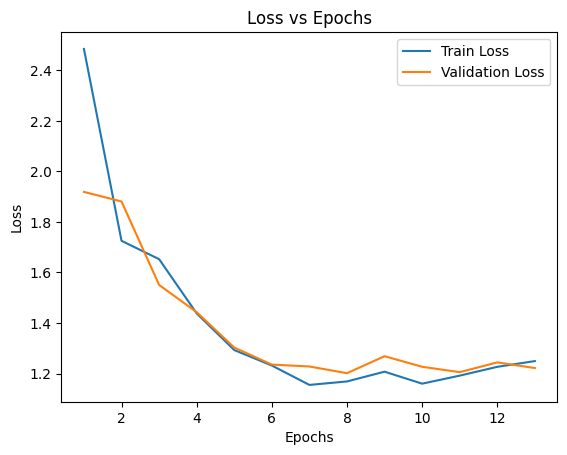

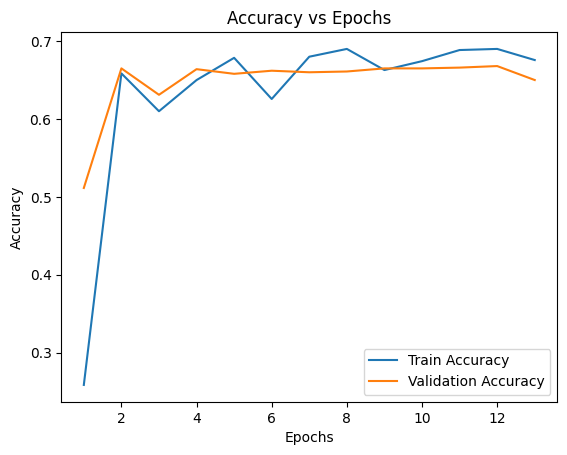

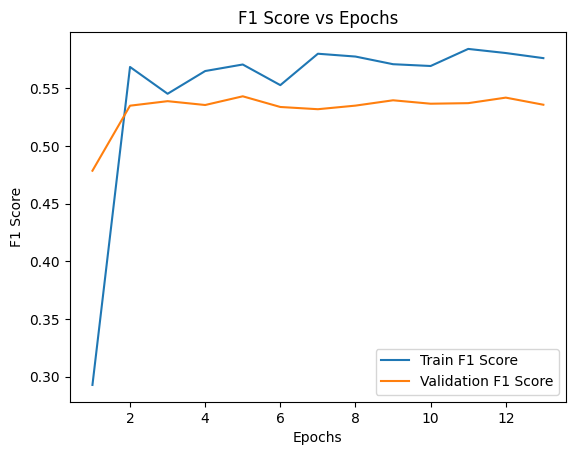

Run 3 => ValAcc: 0.6500, ValF1: 0.5359, ValLoss: 1.2216

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 1.2947 ± 0.0865
Validation Accuracy: 0.6613 ± 0.0082
Validation F1: 0.5369 ± 0.0011

 Final Val Accuracy = 0.6613 ± 0.0082


In [59]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    percentage = 10
    embeddings_file = "/home/dime/Desktop/Pre-thesis/propagated_embeddings.pth"

    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=percentage,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42,
        embeddings_path=embeddings_file
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")
